# Exercise 6

Today we want to study the similarity between two most dangerous viruses ;) ... NC_019495.1 and NC_019491.1
As (bio)informatician you will be ask to came up with a nice similarity maesurement between both strains.
From you study you know that biologists love plots and you know that there are [syntenic](https://genomevolution.org/wiki/index.php/Syntenic_dotplot) [plots](http://en.wikipedia.org/wiki/Synteny).

##### Task 1: (2 points)

Summarise in your own words the definition of a syntenic plot.

A syntetic plot is scatter-like plot which represents the sequence similarities between two sets of genomes, and therefore it shows the conservation level within these two sets.

##### Task 2: (15 points)

Compare both genomes on a nucleotide level. For that purpose iterate over both genomes with a meaningful window-size. For every window save the window start position. For each window in genome A, find exact matches in genome B and save the corresponding position. You should have for every window two coordinates. Plot them in a scatterplot and create your first own syntenic plot.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from Bio import Entrez, SeqIO

Entrez.email = "arber.zela21@gmail.com"
# fetch the first virus data:
handle = Entrez.efetch(db='nucleotide', id='422933791', rettype='gb')
rec1 = SeqIO.read(handle, "gb")

# fetch the second virus data:
handle = Entrez.efetch(db='nucleotide', id='422933554', rettype='gb')
rec2 = SeqIO.read(handle, "gb")

# window size 18 was chosen since it is a multiple of 3 and the dots in the syntenic plot are not few but also not too many.
window = 18

# function for returning all the sequences of the given window size for the record as a dictionary.
def sequences(record):
    seq_dict = dict()
    for i in range(len(record) - window):
        section = record[i:i+window]
        if str(section) in seq_dict:
            seq_dict[str(section)].append(i)
        else:
            seq_dict[str(section)] = [i]
    return seq_dict

# dictionaries that contain the sequences as keys and the starting position as value.
dict1 = sequences(rec1.seq)
dict2 = sequences(rec2.seq)

# set which contains all the common sequences between the two records.
matches = set(dict1).intersection(dict2)

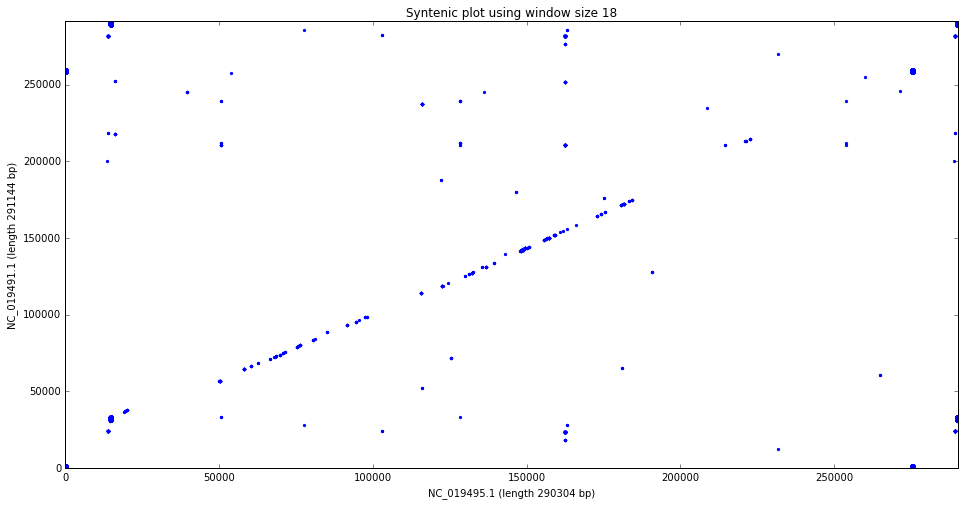

In [3]:
# create lists x and y which contain the starting position of the matched sequences.
x = []
y = []
for seq in matches:
    for i in dict1[seq]:
        for j in dict2[seq]:
            x.append(i)
            y.append(j)
        
# scatter plot with lists x and y as its values.
pylab.figure(figsize=(16,8))
pylab.scatter(x, y, marker='.', color='blue')
pylab.title("Syntenic plot using window size %i" % window)
pylab.xlabel("%s (length %i bp)" % (rec1.id, len(rec1)))
pylab.ylabel("%s (length %i bp)" % (rec2.id, len(rec2)))
pylab.xlim(0, len(rec1)-window)
pylab.ylim(0, len(rec2)-window)
pylab.show()

##### Task 3: (15 points)

As you have learned at the beginning of our course the intragenic regions can vary a lot between genomes, even if they are closely related. To enhance your previous solution you need to create a plot based on proteins, their location and their similarity.
Please iterate over your genome, extract the protein sequences from NC_019495.1 and NC_019491.1 and compare them with each other. You can assume that the sequences with the highest similarity are homologous, they should get one dot in your scatterplot.

Hint: BioPython offers some nice modules to calculate pairwise similarities.

In [4]:
from Bio import Entrez, SeqIO
from Bio import pairwise2
import matplotlib.patches as mpatches

Entrez.email = "arber.zela21@gmail.com"
# fetch the first virus data:
handle = Entrez.efetch(db='nucleotide', id='NC_019495.1', rettype='gb')
record1 = SeqIO.read(handle, "gb")

# fetch the second virus data:
handle = Entrez.efetch(db='nucleotide', id='NC_019491.1', rettype='gb')
record2 = SeqIO.read(handle, "gb")

# function for extracting the CDS sequences from the records and translating them into the corresponding protein sequences.
# it returns a dictionary which contains the protein sequences as keys and the corresponding locations as key values.
def extract_proteins(record):
    proteins = {}
    for feature in record.features:
        if feature.type == 'CDS':
            protein = feature.extract(record.seq).translate(to_stop=True).upper()
            proteins[str(protein)] = feature.location.start.position
    return proteins

# virus 1 proteins
proteins_dict1 = extract_proteins(record1)
# virus 2 proteins
proteins_dict2 = extract_proteins(record2)

# function for finding the best match for each protein in the first argument wrt the proteins of the second argument.
# it returns a list which contains the starting location of these matches.
def extract_homologs(proteins1, proteins2):
    homologs_positions = list()
    for seq1 in proteins1:
        pos1 = proteins1[seq1]
        pos2 = list()
        max_score = 0
        for seq2 in proteins2:
            # this function returns the best global alignment score for the two sequences.
            score = pairwise2.align.globalms(seq1, seq2, 2, -1, -.5, -.1, one_alignment_only=1, score_only=1)
            if score > max_score:
                pos2 = []
                pos2.append(proteins2[seq2])
                max_score = score
            elif score == max_score:
                pos2.append(proteins2[seq2])    # the case when we have two or more equal best scores from protein2.
        for p in pos2:
            homologs_positions.append([pos1,p])
    return homologs_positions

# function for extracting the locations of the homolog proteins CDSs in the genomes which will be used for the scatter plot.
def extract_coordinates(homologs):
    x = []
    y = []
    for pos in homologs:
        x.append(pos[0])
        y.append(pos[1])
    return x, y

In [5]:
# homologs for the virus 1 proteins wrt those of virus 2.
homologs_positions1 = extract_homologs(proteins_dict1, proteins_dict2)
x, y = extract_coordinates(homologs_positions1)

# homologs for the virus 2 proteins wrt those of virus 1.
homologs_positions2 = extract_homologs(proteins_dict2, proteins_dict1)
v, u = extract_coordinates(homologs_positions2)

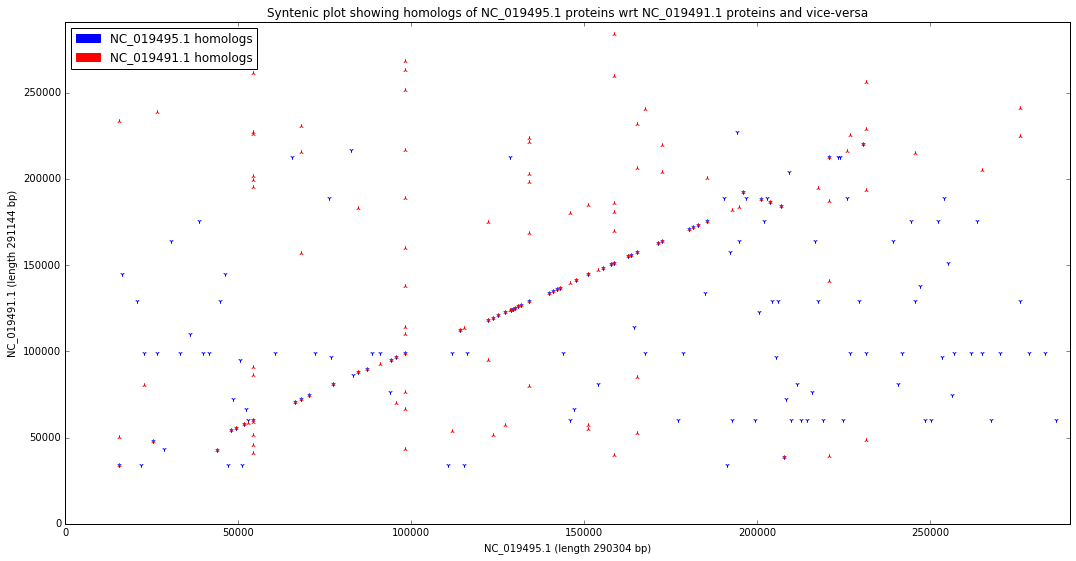

In [6]:
# the only thing left is creating the scatter plot.
pylab.figure(figsize=(18,9))
pylab.scatter(x, y, marker='1', color='blue')
pylab.scatter(u, v, marker='2', color='red')
pylab.xlim(0, len(record1))
pylab.ylim(0, len(record2))
pylab.xlabel("%s (length %i bp)" % (record1.id, len(record1)))
pylab.ylabel("%s (length %i bp)" % (record2.id, len(record2)))
pylab.title("Syntenic plot showing homologs of %s proteins wrt %s proteins and vice-versa" % (record1.id, record2.id))
red_patch = mpatches.Patch(color='blue', label=str(record1.id) + " homologs")
blue_patch = mpatches.Patch(color='red', label=str(record2.id) + " homologs")
pylab.legend(handles=[red_patch,blue_patch], loc = 2)
pylab.show()

##### Task 4:

Explain both plots and compare them with each other. What is the best approach and why? What can be improved and finally what do you answer your biologist?

The first plot shows the starting positions of sequences with a fixed window size from both genomes which are exactly the same. The second plot shows for each protein in the first virus the protein in the second virus for which we get the best global alignment score and vice versa. So this means that these two proteins are probably homologous. So each dot in the plots represents the starting position of the CDS which encode proteins that are probably homologous. If the task is to find sequence similarity between both genomes I would suggest the first approach. Nevertheless, the second approach is more concrete in the evolutionary context. In the first approach we have a fixed window size and not all the sequences that match are CDS that encode a protein, meanwhile in the second one we only compare the CDS which may not be the same but they encode highly similar proteins. Therefore, if we want to know if the organisms are descendants of a common ancestor the second approach is more appropriate. For the second plot to make the plot more meaningful we could scale the size of the dots with respect to the alignment score (similar as in the probability dot plots). As we can see from both plots, the dots are placed in a highly linear way. This means that both the sequences and the proteins encoded by these genomes are the same in the same positions in both genomes. This also means that the organisms are similar and most probably homologous.